In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile

## VEST's Documentation File

## Election Results

Election results are from Oklahoma State Election Board (https://results.okelections.us/OKER/?elecDate=20201103).

## Shape Files
Precinct shapefile from Oklahoma GIS Data Warehouse (https://csagis-uok.opendata.arcgis.com/).

RDH note: shapefile for GIS data warehouse here: https://csagis-uok.opendata.arcgis.com/datasets/c83b09af406d48f7bbca30942fe186a8_0/explore?location=35.317799%2C-98.716567%2C8.77

## Processing
Early votes were reported countywide for Oklahoma County and Tulsa County. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.

## Races

- G20PRERTRU - Donald J. Trump (Republican Party) 
- G20PREDBID - Joseph R. Biden (Democratic Party) 
- G20PRELJOR - Jo Jorgensen (Libertarian Party)
- G20PREIWES - Kanye West (Independent)
- G20PREISIM - Jade Simmons (Independent)
- G20PREIPIE - Brock Pierce (Independent)
- G20USSRINH - Jim Inhofe (Republican Party)
- G20USSDBRO - Abby Broyles (Democratic Party)
- G20USSLMUR - Robert Murphy (Libertarian Party)
- G20USSIFAR - Joan Farr (Independent)
- G20USSINES - A.D. Nesbit (Independent)
- G20COCRHIE - Todd Hiett (Republican Party)
- G20COCLHAG - Todd Hagopian (Libertarian Party)

## Load in VEST's Final File

In [9]:
vest_shp = gp.read_file("raw_from_source/VEST/ok_2020/ok_2020.shp")

In [10]:
vest_shp.shape

(1948, 19)

In [29]:
vest_shp.head()


,STATEFP,COUNTYFP,COUNTY_NAM,PCT_CEB,GEOID,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREIWES,G20PREISIM,G20PREIPIE,G20USSRINH,G20USSDBRO,G20USSLMUR,G20USSIFAR,G20USSINES,G20COCRHIE,G20COCLHAG,geometry
0,40,063,Hughes,320010,40063320010,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-96.31855 35.02881, -96.31878 35.028..."
1,40,143,Tulsa,720175,40143720175,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-95.92251 36.18026, -95.92256 36.180..."
2,40,109,Oklahoma,550256,40109550256,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-97.65129 35.72594, -97.65083 35.725..."
3,40,017,Canadian,090399,40017090399,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-97.77765 35.38274, -97.77764 35.386..."
4,40,143,Tulsa,720174,40143720174,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-95.92526 36.17711, -95.92585 36.177..."


<AxesSubplot:>

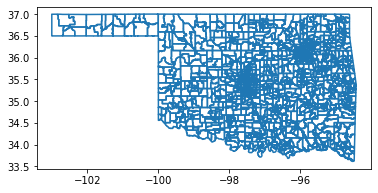

In [12]:
vest_shp.boundary.plot()

<AxesSubplot:>

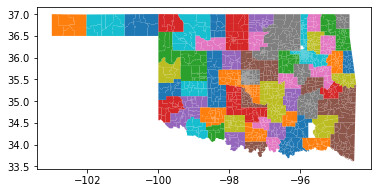

In [26]:
vest_shp.plot(column='COUNTYFP')

In [13]:
vest_shp.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTY_NAM', 'PCT_CEB', 'GEOID', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREIWES', 'G20PREISIM', 'G20PREIPIE',
       'G20USSRINH', 'G20USSDBRO', 'G20USSLMUR', 'G20USSIFAR', 'G20USSINES',
       'G20COCRHIE', 'G20COCLHAG', 'geometry'],
      dtype='object')

## Load the SOS Election Results File

In [20]:
ok_20 = pd.read_csv("raw_from_source/precinct_results/20201103_PrecinctResults.csv", index_col=False)

In [21]:
ok_20.head()

,elec_date,precinct,entity_description,race_number,race_description,race_party,tot_race_prec,race_prec_reporting,cand_number,cand_name,cand_party,cand_absmail_votes,cand_early_votes,cand_elecday_votes,cand_tot_votes,race_county_owner
0,11/3/2020,10001,"FEDERAL, STATE AND COUNTY",10001,FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT,NaN,1948,1948,1,DONALD J. TRUMP | MICHAEL R. PENCE,REP,16,43,219,278,NaN
1,11/3/2020,10001,"FEDERAL, STATE AND COUNTY",10001,FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT,NaN,1948,1948,2,JO JORGENSEN | JEREMY SPIKE COHEN,LIB,2,0,3,5,NaN
2,11/3/2020,10001,"FEDERAL, STATE AND COUNTY",10001,FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT,NaN,1948,1948,3,JOSEPH R. BIDEN | KAMALA D. HARRIS,DEM,5,7,53,65,NaN
3,11/3/2020,10001,"FEDERAL, STATE AND COUNTY",10001,FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT,NaN,1948,1948,4,JADE SIMMONS | CLAUDELIAH J. ROZE,IND,0,0,3,3,NaN
4,11/3/2020,10001,"FEDERAL, STATE AND COUNTY",10001,FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT,NaN,1948,1948,5,KANYE WEST | MICHELLE TIDBALL,IND,0,0,2,2,NaN


In [28]:
ok_20.shape

(80080, 16)

## Clean Up the Elections Results

In [34]:
#filter rows with presidential, Senatorial, and Corporate Commissioner results
filtered_20 = ok_20.loc[(ok_20['race_description']== 'FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT') | (ok_20['race_description']== 'FOR UNITED STATES SENATOR') | (ok_20['race_description']== 'FOR CORPORATE COMMISSIONER')]
print(filtered_20)
ok_unq = ok_20['race_description'].value_counts()
print(ok_unq)

       elec_date  precinct         entity_description  race_number  \
0      11/3/2020     10001  FEDERAL, STATE AND COUNTY        10001   
1      11/3/2020     10001  FEDERAL, STATE AND COUNTY        10001   
2      11/3/2020     10001  FEDERAL, STATE AND COUNTY        10001   
3      11/3/2020     10001  FEDERAL, STATE AND COUNTY        10001   
4      11/3/2020     10001  FEDERAL, STATE AND COUNTY        10001   
...          ...       ...                        ...          ...   
80053  11/3/2020    770307  FEDERAL, STATE AND COUNTY        10003   
80054  11/3/2020    770307  FEDERAL, STATE AND COUNTY        10003   
80055  11/3/2020    770307  FEDERAL, STATE AND COUNTY        10003   
80056  11/3/2020    770307  FEDERAL, STATE AND COUNTY        10003   
80057  11/3/2020    770307  FEDERAL, STATE AND COUNTY        10003   

                                    race_description  race_party  \
0      FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT         NaN   
1      FOR ELECTORS FOR